# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-5/memory_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 记忆型智能体（Memory Agent）

## 回顾

我们已经构建过一个聊天机器人，它可以将语义型记忆保存到单一的[用户画像（profile）](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)或[集合（collection）](https://langchain-ai.github.io/langgraph/concepts/memory/#collection)中。

我们还引入了 [Trustcall](https://github.com/hinthornw/trustcall)，用于对上述任一模式（schema）进行结构化更新。

## 目标

现在，我们将把已学的组件组合起来，构建一个具备长期记忆能力的[智能体（agent）](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/)。

本次我们创建的智能体 `task_assistant` 将帮助我们管理一个待办清单（ToDo list）。

此前的聊天机器人会在每轮对话后都进行反思并保存记忆。

而 `task_assistant` 会自主决定“何时”保存记忆（即是否把内容加入待办）。

此前的聊天机器人只会保存一种类型的记忆（profile 或 collection）。

**`task_assistant` 可以决定将信息保存到用户画像，或保存为待办清单中的任务集合。**

除了语义记忆，`task_assistant` **还会管理“过程性记忆”（procedural memory）。**

这使得用户可以更新“如何创建待办项”的偏好与原则（例如是否偏好包含本地商家等）。

In [1]:
%%capture --no-stderr
# %pip install -U langchain_openai langgraph trustcall langchain_core
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 trustcall==0.0.39

In [2]:
import os, getpass

def _set_env(var: str):
    # 检查该环境变量是否已在操作系统环境中设置
    env_value = os.environ.get(var)
    if not env_value:
        # 如未设置，则提示用户输入
        env_value = getpass.getpass(f"{var}: ")

    # 将环境变量设置到当前进程
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "FlyAIBox"

LANGSMITH_API_KEY: ··········


In [3]:
# 设置OpenAI API密钥
# 您需要从 https://api.apiyi.com/v1 获取API密钥
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


## 观察 Trustcall 的更新细节

Trustcall 会创建和更新 JSON 模式（schema）。

如果我们想了解 Trustcall 具体做了哪些“结构化变更”，该怎么办？

例如，Trustcall 自带了一些工具可以：

- 自动纠正校验失败的结果（self-correct）——参见示例追踪：[链接](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7)
- 更新已有文档（patch/更新）——参见示例追踪：[链接](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

对这些工具行为保持可见性，有助于我们后续构建的智能体进行调试与解释。

下面将展示如何实现！

In [4]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="记忆的主要内容。例如：用户表达了想要学习法语的兴趣。")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="关于用户的一组记忆条目。")

我们可以给 Trustcall 的抽取器添加一个[监听器（listener）](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners)。

这样会将抽取器执行过程中的运行记录（runs）传递给我们自定义的 `Spy` 类。

`Spy` 会提取 Trustcall 实际调用了哪些工具、对应的调用 ID 与参数，便于审计与调试。

---
`Spy` 帮我们记录下了 Trustcall 调用的工具信息，但这只是原始数据。为了更直观地看到 Trustcall 到底做了哪些“结构化变更”，我们需要对这些原始信息进行处理。

`extract_tool_info` 函数就是用来做这件事的。它就像一个“翻译官”，把 `Spy` 记录的工具调用“翻译”成我们能理解的“变更摘要”。

In [5]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# 检查 Trustcall 实际触发的工具调用
# 这个 Spy 类就像一个“间谍”，用来监听和记录 Trustcall 在抽取过程中实际调用了哪些工具。
class Spy:
    def __init__(self):
        # 这个列表用来存放捕获到的工具调用信息。
        self.called_tools = []

    # 这个方法是监听器实际执行的功能。
    # 当 Trustcall 内部发生一个“运行”（run）时，比如调用模型或工具，这个方法就会被调用。
    # 'run' 参数包含了这次运行的详细信息。
    def __call__(self, run):
        # 这里我们通过一个队列来遍历当前运行及其所有的子运行（child_runs）。
        # 这是因为 Trustcall 的内部执行可能是一个复杂的流程，包含多个嵌套的运行。
        q = [run]
        while q:
            r = q.pop()
            # 如果当前运行有子运行，就把它们添加到队列中，以便后续检查。
            if r.child_runs:
                q.extend(r.child_runs)
            # 我们主要关注类型为“chat_model”的运行，这表示聊天模型被调用了。
            # 模型在生成回复时，可能会决定调用工具。
            if r.run_type == "chat_model":
                # 从模型的输出中提取出工具调用的信息。
                # 这些信息通常在模型的生成结果的特定位置。
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# 初始化监听器（Spy）实例
spy = Spy()

# 初始化聊天模型。Trustcall 会使用这个模型来执行抽取和可能的工具调用。
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 创建 Trustcall 抽取器。
# 这个抽取器配置为使用我们定义的 Memory schema 作为工具。
# tool_choice="Memory" 表示模型应该尝试调用 Memory 工具来结构化信息。
# enable_inserts=True 允许 Trustcall 在需要时插入新的 Memory 文档。
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# 将 Spy 监听器添加到 Trustcall 抽取器上。
# on_end=spy 表示在抽取过程结束时，调用 Spy 实例（即执行 __call__ 方法），从而捕获工具调用信息。
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction（抽取任务说明）
instruction = """从以下对话中抽取记忆（Memories）："""

# 模拟对话内容
conversation = [
    HumanMessage(content="你好，我是 FLY"),
    AIMessage(content="很高兴认识你，FLY"),
    HumanMessage(content="今天早上我在湖边骑自行车")
]

# Invoke the extractor（调用抽取器）
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [7]:
# 消息中包含了工具调用（tool calls）
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_WWtiSYaZW3N0pBg0jqYxkWI2)
 Call ID: call_WWtiSYaZW3N0pBg0jqYxkWI2
  Args:
    content: FLY 今天早上在湖边骑自行车。


In [8]:
# responses（解析后的结果）包含符合 schema 的记忆
for m in result["responses"]:
    print(m)

content='FLY 今天早上在湖边骑自行车。'


In [9]:
# response_metadata（元信息）包含工具调用的 ID 等信息
for m in result["response_metadata"]:
    print(m)

{'id': 'call_WWtiSYaZW3N0pBg0jqYxkWI2'}


In [10]:
# 模拟对话的延续，用于演示记忆更新
updated_conversation = [
    AIMessage(content="太棒了，之后你做了什么？"),
    HumanMessage(content="我去了咖啡店喝了咖啡"),
    AIMessage(content="你还想说什么？"),
    HumanMessage(content="我在想去日本旅游，想今年冬天再去"),
]
# Update the instruction（系统提示：基于新对话进行更新）
system_msg = """根据下面的对话，更新已有记忆并创建新的记忆："""

# We'll save existing memories, giving them an ID, key (tool name), and value（把已有记忆保存为 (id, 工具名, 值) 的三元组）
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0', 'Memory', {'content': 'FLY 今天早上在湖边骑自行车。'})]

In [11]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation,
                             "existing": existing_memories})

In [12]:
# response_metadata（元信息）包含工具调用的 ID 等信息
for m in result["response_metadata"]:
    print(m)

{'id': 'call_0DHarsWzWxQidhGPrBFG59uj'}
{'id': 'call_8C7OqDmZ5jaCmAh1P7auhqCV'}


In [13]:
# 消息中包含了工具调用（tool calls）
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_0DHarsWzWxQidhGPrBFG59uj)
 Call ID: call_0DHarsWzWxQidhGPrBFG59uj
  Args:
    content: 用户去了咖啡店喝了咖啡。
  Memory (call_8C7OqDmZ5jaCmAh1P7auhqCV)
 Call ID: call_8C7OqDmZ5jaCmAh1P7auhqCV
  Args:
    content: 用户在想去日本旅游，计划今年冬天再去。


In [14]:
# 解析后的 responses
for m in result["responses"]:
    print(m)

content='用户去了咖啡店喝了咖啡。'
content='用户在想去日本旅游，计划今年冬天再去。'


In [15]:
# 查看 Trustcall 在这一步实际调用了哪些工具
spy.called_tools

[[{'name': 'Memory',
   'args': {'content': '用户去了咖啡店喝了咖啡。'},
   'id': 'call_0DHarsWzWxQidhGPrBFG59uj',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': '用户在想去日本旅游，计划今年冬天再去。'},
   'id': 'call_8C7OqDmZ5jaCmAh1P7auhqCV',
   'type': 'tool_call'}]]

In [16]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """从工具调用序列中抽取结构化“变更摘要”。同时支持补丁更新与新增。

    参数：
        tool_calls: 模型产生的工具调用列表（含并行批次）
        schema_name: 目标 schema 名称（如 "Memory"、"ToDo"、"Profile"）
    """

    # 归并工具调用为“变更项”
    changes = []

    # tool_calls 是一个列表的列表，因为模型可能并行调用多个工具。
    # 我们需要遍历每一组工具调用。
    for call_group in tool_calls:
        # 在每一组工具调用中，遍历每一个具体的工具调用。
        for call in call_group:
            # 检查工具调用的名称。Trustcall 在更新已有文档时会调用 'PatchDoc' 工具。
            if call['name'] == 'PatchDoc':
                # 如果是 PatchDoc 调用，说明是更新操作。
                changes.append({
                    'type': 'update', # 标记变更类型为“更新”
                    'doc_id': call['args']['json_doc_id'], # 被更新文档的唯一 ID
                    'planned_edits': call['args']['planned_edits'], # 模型对这次更新的文字描述或计划
                    'value': call['args']['patches'][0]['value'] # 实际更新的内容（补丁的值）
                })
            # 检查工具调用的名称是否与我们关注的 schema 名称一致（例如 "Memory"）。
            # 如果一致，通常表示模型要创建一个符合该 schema 的新文档。
            elif call['name'] == schema_name:
                # 如果是 schema 工具调用，说明是新增操作。
                changes.append({
                    'type': 'new', # 标记变更类型为“新增”
                    'value': call['args'] # 新增文档的具体内容，以字典形式存储
                })

    # 将前面归并的变更信息格式化成更容易阅读的中文文本。
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            # 如果是更新操作，生成一段描述性文本，包含文档 ID、计划和实际更新内容。
            result_parts.append(
                f"文档 {change['doc_id']} 已更新：\n"
                f"计划：{change['planned_edits']}\n"
                f"新增/替换内容：{change['value']}"
            )
        else:
            # 如果是新增操作，生成一段描述性文本，说明创建了新的 schema 文档及其内容。
            result_parts.append(
                f"已创建新的 {schema_name}：\n"
                f"内容：{change['value']}"
            )

    # 最后，使用换行符将所有描述文本连接起来，形成一个完整的变更摘要字符串。
    return "\n\n".join(result_parts)

# 查看抽取阶段的实际变更摘要
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

已创建新的 Memory：
内容：{'content': '用户去了咖啡店喝了咖啡。'}

已创建新的 Memory：
内容：{'content': '用户在想去日本旅游，计划今年冬天再去。'}


## 创建一个智能体

可选的[智能体（agent）](https://langchain-ai.github.io/langgraph/concepts/high_level/)架构有很多。

这里我们实现一个相对简单的 [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) 智能体。

它将作为创建与管理 ToDo 清单的辅助搭档。

该智能体可以自主决定更新三类长期记忆：

(a) 创建/更新用户 `profile`（用户的基本信息）

(b) 在 ToDo 列表 `collection` 中新增/更新任务

(c) 更新它自己用于维护 ToDo 列表的 `instructions`（操作准则）

In [17]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

## 图定义（Graph definition）

我们添加一个简单的路由器 `route_message`，它会做一个二元决策：是否需要保存记忆，以及保存到哪一类长期记忆中。

记忆集合（ToDo、Profile 等）的结构化更新由 `Trustcall` 负责，与前面的示例一致。

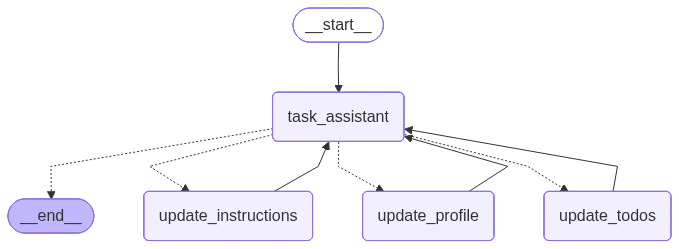

In [18]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

# Initialize the model（初始化聊天模型）
model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """当前聊天用户的画像（基本信息）"""
    name: Optional[str] = Field(description="用户姓名", default=None)
    location: Optional[str] = Field(description="用户所在城市/地区", default=None)
    job: Optional[str] = Field(description="用户的职业", default=None)
    connections: list[str] = Field(
        description="与用户相关的个人关系，如家人、朋友或同事",
        default_factory=list
    )
    interests: list[str] = Field(
        description="用户的兴趣爱好",
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="要完成的任务")
    time_to_complete: Optional[int] = Field(description="预计完成所需时间（分钟）")
    deadline: Optional[datetime] = Field(
        description="任务的截止时间（如适用）",
        default=None
    )
    solutions: list[str] = Field(
        description="可执行的解决方案清单（例如：具体想法、服务商、可落地的操作选项等）",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="任务当前状态",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile（用于更新用户画像的 Trustcall 抽取器）
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call
MODEL_SYSTEM_MESSAGE = """你是一名乐于助人的聊天机器人。

你的职责是作为用户的日常助手，帮助他们维护 ToDo 待办清单。

你拥有一份长期记忆，记录三类信息：
1. 用户画像（profile）：关于用户的一般性信息
2. ToDo 列表：与用户任务相关的事项
3. 维护 ToDo 列表的操作准则（instructions）

以下是当前的用户画像（如果尚未收集信息，可能为空）：
<user_profile>
{user_profile}
</user_profile>

以下是当前的 ToDo 列表（如果尚未添加任务，可能为空）：
<todo>
{todo}
</todo>

以下是用户目前指定的 ToDo 维护偏好（如果尚未指定，可能为空）：
<instructions>
{instructions}
</instructions>

你的推理与行动规范如下：

1. 认真理解下方的用户消息与上下文。

2. 判断是否需要更新长期记忆中的任一部分：
- 如果用户提供了个人信息，调用 UpdateMemory 工具并传入类型 `user`，用于更新用户画像
- 如果用户提到任务，调用 UpdateMemory 工具并传入类型 `todo`，用于更新 ToDo 列表
- 如果用户给出了如何维护 ToDo 的偏好/原则，调用 UpdateMemory 工具并传入类型 `instructions`，用于更新操作准则

3. 在合适的情况下向用户反馈“记忆已更新”：
- 不要告知用户你更新了用户画像
- 当你更新了 ToDo 列表时，应当明确告知
- 不要告知用户你更新了操作准则

4. 在是否更新 ToDo 列表的问题上，宁可“多更新”也无需事先征求许可。

5. 无论是否进行了工具调用，都要自然地继续与用户对话。"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """请认真回顾以下交互内容。

使用提供的工具，保留与用户相关的必要记忆。

如果需要同时进行“更新已有文档”和“新增文档”，请使用并行工具调用以提升效率。

系统时间：{time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """请回顾以下交互内容。

基于这次交互，更新你“如何维护 ToDo 列表条目”的操作准则。

利用用户反馈，调整添加/更新条目的方式（例如是否偏好包含本地商家等）。

你当前的准则如下：

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_assistant(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    task_assistant 节点：这是智能体接收用户消息并进行初步处理的地方。
    它的主要作用是：
    1. 从长期存储中加载用户的个性化记忆（用户画像、ToDo 列表、操作准则）。
    2. 将这些记忆整合到系统提示中，用于指导模型的回复。
    3. 调用模型，让模型根据用户消息和系统提示决定是否需要更新长期记忆（通过调用 UpdateMemory 工具）并生成回复。
    """

    # 从配置中获取当前用户的唯一 ID。这个 ID 用于区分不同用户的长期记忆。
    user_id = config["configurable"]["user_id"]

    # --- 加载长期记忆 ---

    # 1. 读取用户画像（profile）记忆
    # 构建命名空间 (namespace)。命名空间是 Trustcall Store 中用于组织和隔离数据的方式。
    # 这里使用 ("profile", user_id) 作为命名空间，表示这是特定用户 (user_id) 的用户画像数据。
    namespace = ("profile", user_id)
    # 从存储中搜索该命名空间下的所有记忆。用户画像通常只有一个文档。
    memories = store.search(namespace)
    # 如果找到了记忆，提取第一个（也是唯一一个）记忆的值。
    if memories:
        user_profile = memories[0].value
    else:
        # 如果没有找到，说明还没有用户画像记忆，设置为 None。
        user_profile = None

    # 2. 读取 ToDo 列表记忆
    # 构建 ToDo 列表的命名空间。
    namespace = ("todo", user_id)
    # 从存储中搜索该命名空间下的所有 ToDo 记忆。ToDo 列表可能包含多个任务。
    memories = store.search(namespace)
    # 将所有 ToDo 记忆的值（每个任务的描述）用换行符连接起来，形成一个字符串。
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # 3. 读取用户偏好/操作准则（instructions）记忆
    # 构建操作准则的命名空间。
    namespace = ("instructions", user_id)
    # 从存储中搜索该命名空间下的所有操作准则记忆。操作准则通常只有一个文档。
    memories = store.search(namespace)
    # 如果找到了记忆，提取第一个（也是唯一一个）记忆的值。
    if memories:
        instructions = memories[0].value
    else:
        # 如果没有找到，说明还没有操作准则记忆，设置为空字符串。
        instructions = ""

    # --- 构建系统提示 ---

    # 使用加载的记忆信息格式化主系统提示 (MODEL_SYSTEM_MESSAGE)。
    # 这会将用户的 profile, todo 列表和 instructions 嵌入到提示中，
    # 让模型在生成回复时能够参考这些个性化信息。
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # --- 调用模型生成回复和工具调用 ---

    # 调用聊天模型。
    # bind_tools([UpdateMemory], parallel_tool_calls=False) 表示模型在生成回复时，
    # 可以选择调用 UpdateMemory 工具，并且每次只调用一个工具 (parallel_tool_calls=False)。
    # invoke(...) 传入系统消息和当前的对话历史 (state["messages"])。
    # 模型会根据这些信息生成回复，如果判断需要更新记忆，则会包含 UpdateMemory 的工具调用。
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    # 返回模型的回复。这个回复会包含模型的文本回复以及可能存在的工具调用信息。
    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    update_profile 节点：负责处理模型调用 UpdateMemory 工具并指定 update_type 为 'user' 的情况。
    它的主要作用是：
    1. 回顾对话历史，从中提取与用户画像相关的信息。
    2. 使用 Trustcall 抽取器更新长期存储中的用户画像记忆。
    """

    # 从配置中获取当前用户的唯一 ID。这个 ID 用于区分不同用户的长期记忆。
    user_id = config["configurable"]["user_id"]

    # 定义记忆的命名空间。Trustcall Store 使用命名空间来组织和隔离不同类型或不同用户的记忆。
    # 这里使用 ("profile", user_id) 作为命名空间，表示这是特定用户 (user_id) 的用户画像数据。
    namespace = ("profile", user_id)

    # 从存储中检索当前用户已有的用户画像记忆，作为 Trustcall 抽取器进行更新的上下文。
    # 如果之前没有用户画像，这里将返回空列表。
    existing_items = store.search(namespace)

    # 将现有的记忆格式化为 Trustcall 抽取器所需的输入格式。
    # Trustcall 在进行更新时，需要知道现有文档的 ID、类型（schema 名称）和值。
    tool_name = "Profile" # 指定要更新的 schema 名称为 "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items # 如果 existing_items 不为空，则进行列表推导
                          else None # 否则设置为 None
                        )

    # 合并系统指令和对话历史。Trustcall 抽取器需要完整的对话上下文来提取信息。
    # TRUSTCALL_INSTRUCTION 是一个包含通用抽取指令的字符串模板。
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat()) # 格式化指令，加入当前时间
    # merge_message_runs 用于合并消息列表。这里将系统指令和对话历史 (除了最后一个工具调用消息) 合并。
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # 调用 Trustcall 抽取器。
    # Trustcall 会根据提供的消息和现有记忆，决定是新增用户画像还是更新现有的。
    result = profile_extractor.invoke({"messages": updated_messages,
                                         "existing": existing_memories})

    # 将 Trustcall 抽取出的新记忆或更新后的记忆保存到长期存储 (store) 中。
    # result["responses"] 包含抽取出的符合 Profile schema 的 Pydantic 对象。
    # result["response_metadata"] 包含抽取出的对象的元信息，如 json_doc_id（如果 Trustcall 决定更新现有文档）。
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        # store.put 方法用于将数据存入存储。
        # namespace: 指定存储的命名空间。
        # key: 存储项的键。如果 Trustcall 返回了 json_doc_id，说明是更新，使用该 ID 作为键；否则生成一个新的 UUID 作为新文档的键。
        # value: 要存储的值。这里将抽取出的 Pydantic 对象转换为 JSON 格式的字典。
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    # 获取 task_assistant 节点发出的工具调用信息。
    tool_calls = state['messages'][-1].tool_calls
    # 返回一个工具消息 (ToolMessage)，表示 update_profile 节点已经执行完毕，
    # 并将结果 ("updated profile") 发送回 task_assistant 节点。
    # "tool_call_id" 用于关联这个 ToolMessage 和 task_assistant 发出的原始工具调用。
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    update_todos 节点：负责处理模型调用 UpdateMemory 工具并指定 update_type 为 'todo' 的情况。
    它的主要作用是：
    1. 回顾对话历史，从中提取与 ToDo 任务相关的信息。
    2. 使用 Trustcall 抽取器更新长期存储中的 ToDo 列表记忆（新增或更新任务）。
    3. 提取 Trustcall 的具体变更信息，并作为工具调用的结果返回给 task_assistant 节点。
    """

    # 从配置中获取当前用户的唯一 ID。这个 ID 用于区分不同用户的长期记忆。
    user_id = config["configurable"]["user_id"]

    # 定义记忆的命名空间。Trustcall Store 使用命名空间来组织和隔离不同类型或不同用户的记忆。
    # 这里使用 ("todo", user_id) 作为命名空间，表示这是特定用户 (user_id) 的 ToDo 数据。
    namespace = ("todo", user_id)

    # 从存储中检索当前用户已有的 ToDo 记忆，作为 Trustcall 抽取器进行更新的上下文。
    # 如果之前没有 ToDo，这里将返回空列表。
    existing_items = store.search(namespace)

    # 将现有的记忆格式化为 Trustcall 抽取器所需的输入格式。
    # Trustcall 在进行更新时，需要知道现有文档的 ID、类型（schema 名称）和值。
    tool_name = "ToDo" # 指定要更新的 schema 名称为 "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items # 如果 existing_items 不为空，则进行列表推导
                          else None # 否则设置为 None
                        )

    # 合并系统指令和对话历史。Trustcall 抽取器需要完整的对话上下文来提取信息。
    # TRUSTCALL_INSTRUCTION 是一个包含通用抽取指令的字符串模板。
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat()) # 格式化指令，加入当前时间
    # merge_message_runs 用于合并消息列表。这里将系统指令和对话历史 (除了最后一个工具调用消息) 合并。
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall（初始化监听器以观察 Trustcall 工具调用）
    spy = Spy()

    # Create the Trustcall extractor for updating the ToDo list（用于更新 ToDo 的 Trustcall 抽取器）
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages,
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store（将 Trustcall 抽取出的新记忆或更新后的记忆保存到长期存储 (store) 中）
    # result["responses"] 包含抽取出的符合 ToDo schema 的 Pydantic 对象。
    # result["response_metadata"] 包含抽取出的对象的元信息，如 json_doc_id（如果 Trustcall 决定更新现有文档）。
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        # store.put 方法用于将数据存入存储。
        # namespace: 指定存储的命名空间。
        # key: 存储项的键。如果 Trustcall 返回了 json_doc_id，说明是更新，使用该 ID 作为键；否则生成一个新的 UUID 作为新文档的键。
        # value: 要存储的值。这里将抽取出的 Pydantic 对象转换为 JSON 格式的字典。
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

    # Respond to the tool call made in task_assistant, confirming the update（响应 task_assistant 节点发出的工具调用，确认更新已完成）
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_assistant（提取 Trustcall 进行的具体变更信息，并作为工具调用的结果返回给 task_assistant 节点）
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    update_instructions 节点：负责处理模型调用 UpdateMemory 工具并指定 update_type 为 'instructions' 的情况。
    它的主要作用是：
    1. 回顾对话历史，从中提取用户关于如何维护 ToDo 列表的偏好/原则。
    2. 调用模型根据这些偏好更新长期存储中的操作准则记忆。
    """

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")

    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}


# Conditional edge（条件边：根据模型的工具调用结果路由）
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:
    """
    route_message 函数：这是图中的条件边，负责根据 task_assistant 节点的输出（特别是模型是否调用了 UpdateMemory 工具及其参数）来决定下一个节点。
    它的主要作用是：
    1. 检查 task_assistant 返回的消息中是否包含工具调用。
    2. 如果没有工具调用，说明模型认为不需要更新记忆，对话结束 (END)。
    3. 如果有工具调用，检查 UpdateMemory 工具的 update_type 参数，并路由到相应的更新节点（update_profile, update_todos, 或 update_instructions）。
    """
    message = state['messages'][-1]
    # 检查最后一条消息是否有工具调用
    if len(message.tool_calls) ==0:
        # 如果没有工具调用，结束对话
        return END
    else:
        # 如果有工具调用，获取第一个工具调用（我们限制了 parallel_tool_calls=False，所以只会有一个）
        tool_call = message.tool_calls[0]
        # 根据工具调用的参数 'update_type' 来决定下一个节点
        if tool_call['args']['update_type'] == "user":
            # 如果是更新用户画像，路由到 update_profile 节点
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            # 如果是更新 ToDo 列表，路由到 update_todos 节点
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            # 如果是更新操作准则，路由到 update_instructions 节点
            return "update_instructions"
        else:
            # 如果 update_type 是未知类型，抛出错误
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
# 添加各个节点到图中
builder.add_node("task_assistant", task_assistant) # 添加 task_assistant 节点
builder.add_node("update_todos", update_todos)     # 添加 update_todos 节点
builder.add_node("update_profile", update_profile) # 添加 update_profile 节点
builder.add_node("update_instructions", update_instructions) # 添加 update_instructions 节点

# 定义边的连接
# 从 START（图的开始）连接到 task_assistant 节点
builder.add_edge(START, "task_assistant")
# 从 task_assistant 节点添加条件边，根据 route_message 函数的返回值决定去向
builder.add_conditional_edges("task_assistant", route_message)
# 从各个更新节点（update_todos, update_profile, update_instructions）连接回 task_assistant 节点，
# 这样在更新完成后，智能体可以回到 task_assistant 继续与用户交互。
builder.add_edge("update_todos", "task_assistant")
builder.add_edge("update_profile", "task_assistant")
builder.add_edge("update_instructions", "task_assistant")

# Store for long-term (across-thread) memory
# 初始化一个内存存储，用于长期（跨会话）记忆。
# 在实际应用中，这里通常会使用数据库等持久化存储。
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
# 初始化一个检查点，用于短期（会话内）记忆。
# 它会保存每个步骤的状态，以便在出现问题时可以从检查点恢复。
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
# 编译图，将节点和边连接起来，并配置检查点和长期存储。
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
# 绘制并显示图的可视化，帮助我们理解智能体的工作流程。
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [19]:
# 提供线程 ID（短期、会话级记忆）
# 提供用户 ID（长期、跨会话记忆）
config = {"configurable": {"thread_id": "1", "user_id": "FLY"}}

# 用户输入：用于创建用户画像（profile）相关记忆
input_messages = [HumanMessage(content="我是FLY。我和妻子生活在中国杭州。我有一个3岁的女儿。")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我是FLY。我和妻子生活在中国杭州。我有一个3岁的女儿。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_kK2lwEy4f7Lm3tOwroIGSMkW)
 Call ID: call_kK2lwEy4f7Lm3tOwroIGSMkW
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

你好，FLY！很高兴认识你。有什么我可以帮忙的吗？


In [20]:
# 用户输入：添加一个 ToDo 任务
input_messages = [HumanMessage(content="我的妻子让我为宝宝预订游泳课程。")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我的妻子让我为宝宝预订游泳课程。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_nGF8JB2idZM5A9Qicb8BVsxR)
 Call ID: call_nGF8JB2idZM5A9Qicb8BVsxR
  Args:
    update_type: todo
================================= Tool Message =================================

已创建新的 ToDo：
内容：{'task': '为3岁的女儿预订游泳课程', 'time_to_complete': 30, 'solutions': ['联系当地的儿童游泳培训机构', '查看杭州的游泳馆是否提供儿童课程', '咨询其他家长推荐的游泳课程'], 'status': 'not started'}
================================== Ai Message ==================================

我已经帮你记录了这个任务：为3岁的女儿预订游泳课程。如果需要进一步帮助，比如查找具体的培训机构或课程信息，请告诉我！


In [21]:
# 用户输入：更新 ToDo 创建/更新的操作准则（instructions）
input_messages = [HumanMessage(content="在创建或更新待办事项时，请包括具体的本地商家/供应商。")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

在创建或更新待办事项时，请包括具体的本地商家/供应商。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_mZigkmcHwE8E031Jhy1wo6Vo)
 Call ID: call_mZigkmcHwE8E031Jhy1wo6Vo
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

好的，我会在创建或更新待办事项时，尽量包括具体的本地商家或供应商。需要我帮你查找杭州的儿童游泳课程吗？


In [22]:
# 检查 instructions 是否已更新
user_id = "FLY"

# 查询持久化存储
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': 'Got it! I will now update the instructions to include specific local businesses or suppliers when creating or updating ToDo list entries.'}


In [25]:
# 用户输入：添加一个新的 ToDo 任务
input_messages = [HumanMessage(content="我需要修理门锁。")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我需要修理门锁。
================================== Ai Message ==================================

这个任务已经记录在你的待办事项中了：修理门锁。如果需要进一步帮助，比如查找具体的锁匠服务，请告诉我！


In [26]:
# 查询用户的 ToDo 记忆集合
user_id = "FLY"

# 遍历输出
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': '为3岁的女儿预订游泳课程', 'time_to_complete': 30, 'deadline': None, 'solutions': ['联系当地的儿童游泳培训机构', '查看杭州的游泳馆是否提供儿童课程', '咨询其他家长推荐的游泳课程'], 'status': 'not started'}
{'task': '修理门锁', 'time_to_complete': 60, 'deadline': None, 'solutions': ['联系杭州本地的锁匠服务', '查看是否有上门修锁服务', '咨询邻居推荐的修锁师傅'], 'status': 'not started'}


In [27]:
# 用户输入：更新已有 ToDo 的截止时间
input_messages = [HumanMessage(content="我需要在11月底之前完成学会游泳。")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我需要在11月底之前完成学会游泳。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_rwCjDcl6eNfb0wesvELmNV6a)
 Call ID: call_rwCjDcl6eNfb0wesvELmNV6a
  Args:
    update_type: todo


ERROR:extraction:2 validation errors for ToDo
task
  Field required [type=missing, input_value={'update_type': 'user'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
time_to_complete
  Field required [type=missing, input_value={'update_type': 'user'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing


================================= Tool Message =================================

已创建新的 ToDo：
内容：{'task': '学会游泳', 'time_to_complete': None, 'deadline': '2025-11-30T23:59:59', 'solutions': ['报名成人游泳课程', '请私人教练进行一对一教学', '利用周末时间自学'], 'status': 'not started'}
================================== Ai Message ==================================

我已经帮你记录了这个目标：在2025年11月底之前学会游泳。如果需要，我可以帮你查找杭州的游泳课程或私人教练信息。随时告诉我！


我们可以看到，Trustcall 对已有记忆执行了“补丁式”更新（patch）：

`https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r`

In [28]:
# 用户输入：再添加一个新的 ToDo 任务
input_messages = [HumanMessage(content="需要在晚上9点前发送会议总结。")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

需要在晚上9点前发送会议总结。
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_fklcF1lBX2Hl1owQZl28Orkd)
 Call ID: call_fklcF1lBX2Hl1owQZl28Orkd
  Args:
    update_type: todo


ERROR:extraction:2 validation errors for ToDo
task
  Field required [type=missing, input_value={'update_type': 'todo'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
time_to_complete
  Field required [type=missing, input_value={'update_type': 'todo'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing


================================= Tool Message =================================

已创建新的 ToDo：
内容：{'task': '发送会议总结', 'time_to_complete': 30, 'deadline': '2025-09-18T21:00:00', 'solutions': ['整理会议记录', '提炼关键点', '通过邮件发送给相关人员'], 'status': 'not started'}
================================== Ai Message ==================================

我已经帮你记录了这个任务：在晚上9点前发送会议总结。如果需要协助整理会议记录或提炼关键点，请告诉我！


In [29]:
# 查询用户最新的 ToDo 记忆集合
user_id = "FLY"

# 遍历输出
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': '为3岁的女儿预订游泳课程', 'time_to_complete': 30, 'deadline': None, 'solutions': ['联系当地的儿童游泳培训机构', '查看杭州的游泳馆是否提供儿童课程', '咨询其他家长推荐的游泳课程'], 'status': 'not started'}
{'task': '修理门锁', 'time_to_complete': 60, 'deadline': None, 'solutions': ['联系杭州本地的锁匠服务', '查看是否有上门修锁服务', '咨询邻居推荐的修锁师傅'], 'status': 'not started'}
{'task': '学会游泳', 'time_to_complete': None, 'deadline': '2025-11-30T23:59:59', 'solutions': ['报名成人游泳课程', '请私人教练进行一对一教学', '利用周末时间自学'], 'status': 'not started'}
{'task': '发送会议总结', 'time_to_complete': 30, 'deadline': '2025-09-18T21:00:00', 'solutions': ['整理会议记录', '提炼关键点', '通过邮件发送给相关人员'], 'status': 'not started'}


现在我们创建一个新的对话线程（thread）。

这会开启一个新的会话。

此前保存在长期存储中的 Profile、ToDos 与 Instructions 会被自动加载并用于个性化回复。

In [30]:
# 提供线程 ID（短期、会话级记忆）
# 提供用户 ID（长期、跨会话记忆）
config = {"configurable": {"thread_id": "2", "user_id": "FLY"}}

# 与聊天机器人对话
input_messages = [HumanMessage(content="我有30分钟，我能完成哪些任务？")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我有30分钟，我能完成哪些任务？
================================== Ai Message ==================================

根据你的 ToDo 列表，以下任务可以在30分钟内完成：

1. **为3岁的女儿预订游泳课程**  
   - 时间估计：30分钟  
   - 建议行动：联系当地的儿童游泳培训机构或查看杭州的游泳馆是否提供儿童课程。

2. **发送会议总结**  
   - 时间估计：30分钟  
   - 建议行动：整理会议记录，提炼关键点，并通过邮件发送给相关人员。

你可以选择其中一个任务开始完成！需要我帮你制定具体的步骤或提供协助吗？


In [31]:
# 与聊天机器人对话
input_messages = [HumanMessage(content="是的，给我一些报名游泳课程的选项。")]

# 运行图（Graph）
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

是的，给我一些报名游泳课程的选项。
================================== Ai Message ==================================

以下是一些在杭州可以为你女儿报名游泳课程的选项：

1. **杭州游泳馆**  
   - 许多游泳馆提供儿童游泳课程，你可以联系离家较近的游泳馆，询问是否有适合3岁孩子的课程。  
   - 推荐：杭州黄龙体育中心游泳馆、杭州奥体中心游泳馆。

2. **儿童游泳培训机构**  
   - **金宝贝游泳中心**：专注于儿童早教和游泳课程，适合3岁孩子。  
   - **水孩子国际游泳学校**：提供专业的儿童游泳课程，注重安全和兴趣培养。

3. **家长推荐**  
   - 你可以咨询其他家长，了解他们推荐的课程或机构，尤其是有孩子在学游泳的朋友。

4. **线上平台查询**  
   - 使用大众点评、美团等平台搜索“儿童游泳课程”，查看评价和课程详情。

你可以从这些选项中选择一个开始联系，或者告诉我你的具体需求，我可以帮你进一步筛选！


追踪（Trace）：

`https://smith.langchain.com/o/7bfa9385-4ac5-468a-a06c-ffd7dbac42ec/projects/p/27f0e396-e7ab-4eac-9501-8df28b729149?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=aa03e9ad-84b7-4c38-98ae-0e87d60690dc&peeked_trace=aa03e9ad-84b7-4c38-98ae-0e87d60690dc`
![](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509181621557.png)